Aim: Develop a CNN model to classify images using and without using dataset.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv('mnist_train_small.csv', header=None)

In [3]:
train.shape

(20000, 785)

In [4]:
epochs = 500
batch_size = 1000

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [6]:
X_train, y_train = train.values[:, 1:], train.values[:, 0]
y_train = F.one_hot(torch.tensor(y_train)).to(dtype=torch.float32, device=device)
X_train = torch.tensor(X_train, dtype=torch.float32, device=device) / 255

In [7]:
X_train.shape, y_train.shape

(torch.Size([20000, 784]), torch.Size([20000, 10]))

In [8]:
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(p=0.2)
        self.l1 = nn.Linear(28 * 28, 512)
        self.l2 = nn.Linear(512, 256)
        self.l3 = nn.Linear(256, 128)
        self.l4 = nn.Linear(128, 64)
        self.l5 = nn.Linear(64, 32)
        self.l6 = nn.Linear(32, 10)
    def forward(self, x):
        out = self.relu(self.l1(x))
        out = self.dropout(out)

        out = self.relu(self.l2(out))
        out = self.dropout(out)

        out = self.relu(self.l3(out))
        out = self.dropout(out)

        out = self.relu(self.l4(out))
        out = self.dropout(out)

        out = self.relu(self.l5(out))
        out = self.dropout(out)

        out = self.softmax(self.l6(out))
        return out

In [9]:
model = ANN().to(device)
print(model)

ANN(
  (relu): ReLU()
  (softmax): Softmax(dim=-1)
  (dropout): Dropout(p=0.2, inplace=False)
  (l1): Linear(in_features=784, out_features=512, bias=True)
  (l2): Linear(in_features=512, out_features=256, bias=True)
  (l3): Linear(in_features=256, out_features=128, bias=True)
  (l4): Linear(in_features=128, out_features=64, bias=True)
  (l5): Linear(in_features=64, out_features=32, bias=True)
  (l6): Linear(in_features=32, out_features=10, bias=True)
)


In [10]:
# Using cross entropy loss
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [11]:
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

loss_history = []
val_loss_history = []
ep_history = []

steps = len(X_train_split)
for e in range(epochs):
    for i in range(0, steps, batch_size):
        x_batch, y_batch = X_train_split[i:i+batch_size], y_train_split[i:i+batch_size]

        # Forward pass
        output = model(x_batch)
        loss = criteria(output, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate training loss
    loss_history.append(loss.item())
    ep_history.append(e)

    # Validation step
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criteria(val_output, y_val)
        val_loss_history.append(val_loss.item())
        print(f"Epoch: {e+1}/{epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")


Epoch: 1/500, Training Loss: 2.3018, Validation Loss: 2.3014
Epoch: 2/500, Training Loss: 2.2997, Validation Loss: 2.2993
Epoch: 3/500, Training Loss: 2.2922, Validation Loss: 2.2918
Epoch: 4/500, Training Loss: 2.2586, Validation Loss: 2.2530
Epoch: 5/500, Training Loss: 2.1918, Validation Loss: 2.1948
Epoch: 6/500, Training Loss: 2.1390, Validation Loss: 2.1520
Epoch: 7/500, Training Loss: 2.0956, Validation Loss: 2.0985
Epoch: 8/500, Training Loss: 2.0409, Validation Loss: 2.0477
Epoch: 9/500, Training Loss: 1.9972, Validation Loss: 2.0016
Epoch: 10/500, Training Loss: 1.9637, Validation Loss: 1.9684
Epoch: 11/500, Training Loss: 1.9182, Validation Loss: 1.9211
Epoch: 12/500, Training Loss: 1.8784, Validation Loss: 1.8741
Epoch: 13/500, Training Loss: 1.8419, Validation Loss: 1.8452
Epoch: 14/500, Training Loss: 1.8078, Validation Loss: 1.8219
Epoch: 15/500, Training Loss: 1.8019, Validation Loss: 1.8083
Epoch: 16/500, Training Loss: 1.7815, Validation Loss: 1.7902
Epoch: 17/500, Tr

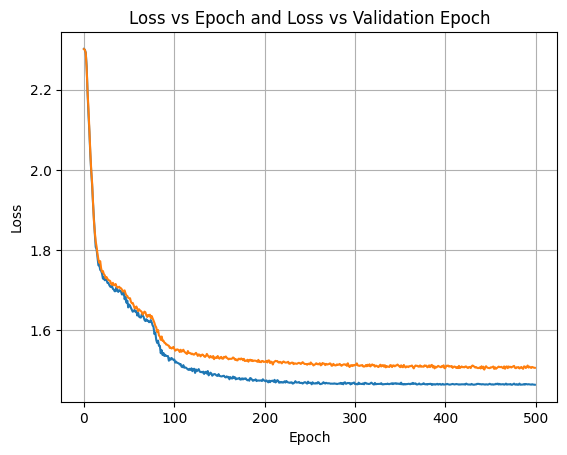

In [12]:
fg = plt.figure()
plt.plot(ep_history, loss_history)
plt.plot(ep_history, val_loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch and Loss vs Validation Epoch")
plt.grid()
plt.show()

In [13]:
test = pd.read_csv('mnist_test.csv', header=None)

In [14]:
test.shape

(10000, 785)

In [15]:
X_test, y_test = test.values[:, 1:], test.values[:, 0]
y_test = F.one_hot(torch.tensor(y_test)).to(dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device) / 255

In [16]:
# Test
with torch.no_grad():
    correct = 0
    total = 0
    for i in range(len(X_test)):
        output = model(X_test[i])
        _, predicted = torch.max(output, 0)
        _, actual = torch.max(y_test[i], 0)
        total += 1
        correct += (predicted == actual).item()
    print(f"Accuracy: {correct/total*100:.2f}%")

Accuracy: 96.05%
